Poppy humanoid robot is a humanoid robot that can be used with its hardware platform or with the CoppeliaSim simulator. It can be programmed with python, using the pypot library.

Download and install the simulator CoppeliaSim from https://www.coppeliarobotics.com/downloads 

# Setup the software

Poppy uses pypot for control. It is a python library : http://poppy-project.github.io/pypot/. 
On the top of pypot are libraries for Poppy creatures : https://github.com/poppy-project.
The quick install consists in:
- install pypot :

In [1]:
#!pip install pypot

- install your poppy creature with its geometry :


In [2]:
#!sudo pip install poppy_torso
#En vrai c'est poppy-torso

- install the library **ikpy** that proposes the inverse kinematics of the robot. The source code is https://github.com/Phylliade/ikpy. See tutorial on https://notebook.community/Phylliade/ikpy/tutorials/Moving%20the%20Poppy%20Torso%20using%20Inverse%20Kinematics)

In [3]:
#!pip install 'ikpy[plot]'

We use another algorithm for human pose estimation : Blazepose :
- the article describing the algorithm is in https://arxiv.org/abs/2006.10204
- the source code is still available at https://github.com/google/mediapipe

To install, use the command : 

In [4]:
#!pip install mediapipe

# Start your code
Now you are done with the installation phase. You can start your project by importing the different libraries

In [1]:
import numpy as np
from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
import os
from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer

## Capture a video with a camera

For this section only, you need to install first opencv.

In [2]:
import cv2
import time

#time.sleep(5)

# Open a connection to the cameras
cap1 = cv2.VideoCapture(0)

Capture the frames of the camera for 10 seconds. Save as file cam1.avi

In [7]:
frame_width_1 = int(cap1.get(3))
frame_height_1 = int(cap1.get(4))
# if you want to change the resolution of the camera
#cap1.set(3,frame_width_1)
#cap1.set(4,frame_height_1)

   
size_1 = (frame_width_1, frame_height_1)

video_nom_1 = "cam1.avi"

# Compression
lossless = cv2.VideoWriter_fourcc(* 'FFV1')

# Save the frame as an video file
video_1 = cv2.VideoWriter(video_nom_1, lossless, 30, size_1)

start = time.time()

while  time.time() < start + 10:

    # Capture a frame from the cameras
    ret1, frame1 = cap1.read()

    # Check if the user pressed the enter key
    cv2.waitKey(1)

    if ret1:
        #cv2.imshow("Webcam 1", frame1) #to display the camera images
        video_1.write(frame1)
    

video_1.release()
            
# Release the camera and close the window
cap1.release()
cv2.destroyAllWindows()

# Instantiate the robot

Now open the simulator CoppeliaSim. Click yes when prompted if you accept all incoming communications.
For MacOs, type in the Sandbox script terminal

simExtRemoteApiStart(19997)

If instead it does now appear and you get an error message like


> pypot.vrep.io.VrepConnectionError: Could not connect to V-REP server on 127.0.0.1:19997. This could also means that you still have a previously opened connection running! (try pypot.vrep.close_all_connections())
>
> During handling of the above exception, another exception occurred:
>
> pypot.vrep.io.VrepIOErrors: No value

type in the Sandbox script terminal

simExtRemoteApiStart(19997)
    

Instantiate the poppy robot in the simulator with the code below, this is necessary in order to add the kinematic chains attributes.

In [3]:
from pypot import vrep
vrep.close_all_connections()
poppy = PoppyTorso(simulator='vrep')

Poppy should now appear on the CoppeliaSim simulation screen, and a popup appeared in CoppeliaSim to inform you that the simulation use custom parameters. This popup block the communication to the Python API of CoppeliaSim. You have to check the check-box “Do not show this message again” and press “Ok”. Do this 3 times.

In [4]:
t = None
targets = None
smoothed_targets = None

For each kinematic chain we have built an urdf file. We create an IKChain object for each kinematic chain, making it possible to compute the inverse kinematics, i.e. motor angles from desired end-effector position.

The constructor takes as input the poppy robot instance, the motors that are part of the kinematic chain, the motors that remain passive during the inverse kinematics, the distance of the tip of the last bone of the chain, and finally, the list of motors for which the urdf file give reversed orientation.

We can plot some of these kinematic chains in a figure. If the position of the robot in the simulator is changed, these changes should be reflected when reexecuting this cell.

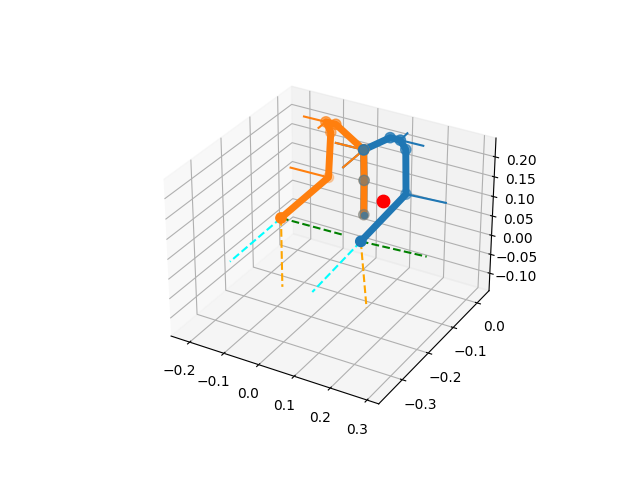

In [5]:
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
zero = [0] * 7

ax = matplotlib.pyplot.figure().add_subplot(111, projection='3d')
ax.scatter([0], [0],[0])

poppy.l_arm_chain.plot(poppy.l_arm_chain.convert_to_ik_angles(poppy.l_arm_chain.joints_position), ax, target = (0.2, -0.2, 0.2))
poppy.r_arm_chain.plot(poppy.r_arm_chain.convert_to_ik_angles(poppy.r_arm_chain.joints_position), ax)


The robot is now ready to use.

# Using the robot Poppy



You can directly access the chains:


In [6]:
print("chaine  " , poppy.l_arm_chain)
print("nom     " , poppy.l_arm_chain.name)
print("links   " , poppy.l_arm_chain.links)
print("1er link" , poppy.l_arm_chain.links[1].name)
#print(poppy.torso_chain)
#print(poppy.l_elbow_chain   )
#print(poppy.l_elbow_chain   )


chaine   Kinematic chain name=chain links=[Link name=Base link bounds=(None, None), Link name=abs_z bounds=(-4583.662227704603, 4583.662227704603), Link name=bust_y bounds=(-3838.817399424839, 1546.9858942315252), Link name=bust_x bounds=(-2291.8311138523013, 2291.8311138523013), Link name=l_shoulder_y bounds=(-6875.493732897918, 8880.845615095293), Link name=l_shoulder_x bounds=(-6016.056820615171, 6302.535660929083), Link name=l_arm_z bounds=(-6016.056820615171, 6016.056820615171), Link name=l_elbow_y bounds=(-8479.775082119413, 57.29545498997201), Link name=last_joint bounds=(None, None)] active_links=[False False False False  True  True  True  True False]
nom      chain
links    [Link name=Base link bounds=(None, None), Link name=abs_z bounds=(-4583.662227704603, 4583.662227704603), Link name=bust_y bounds=(-3838.817399424839, 1546.9858942315252), Link name=bust_x bounds=(-2291.8311138523013, 2291.8311138523013), Link name=l_shoulder_y bounds=(-6875.493732897918, 8880.845615095293)

In [65]:
np.stack([poppy.l_arm_chain.position, poppy.r_arm_chain.position]).shape

(2, 3)

You can access their respective motors

In [7]:
[m.name for m in poppy.l_arm_chain.motors]

['abs_z',
 'bust_y',
 'bust_x',
 'l_shoulder_y',
 'l_shoulder_x',
 'l_arm_z',
 'l_elbow_y']

You can access the state of the robot.

joints_position returns the joint angles for all the motors of the chain

In [8]:
print(poppy.l_arm_chain.joints_position)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
print(poppy.r_arm_chain.joints_position)

[0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0]


position returns the cartesian position of the end effector

In [9]:
print(poppy.l_arm_chain.position)

[ 0.10876056 -0.17632997  0.07149935]


In [11]:
poppy.l_shoulder_y.goto_position(-30,3)
poppy.l_shoulder_x.goto_position(30,3)
poppy.abs_z.goto_position(-20,3)
print(poppy.l_arm_chain.position)

[ 0.10876056 -0.17632997  0.07149935]


Reset the robot to an initial position

In [12]:
def poppy_reset():
    joint_pos = { 'l_elbow_y':0.0,
                 'head_y': 0.0,
                 'r_arm_z': 0.0, 
                 'head_z': 0.0,
                 'r_shoulder_x': 0.0, 
                 'r_shoulder_y': 0.0,
                 'r_elbow_y': 0.0, 
                 'l_arm_z': 0.0,
                 'abs_z': 0.0,
                 'bust_y': 0.0, 
                 'bust_x':0.0,
                 'l_shoulder_x': 0.0,
                 'l_shoulder_y': 0.0
                }
    for m in poppy.motors:
        m.goto_position(joint_pos[m.name],5)

poppy_reset()

In [13]:
from pypot.primitive.move import Move
fps =10

move = Move(freq=fps)
 

print("list of all motors of poppy", [m.name for m in poppy.motors])
move_motors = [m.name for m in poppy.motors]


for t in np.linspace(0.02,3,int(3*fps)):
        new_positions = {}
        for motor in move_motors:
            # decide for each timestep and each motor a joint angle and a velocity
            new_positions[motor] = [20*np.sin(t), 0.0]

        move.add_position(new_positions, t)
        
#print("joint positions of the move ",(move._timed_positions))

list of all motors of poppy ['l_elbow_y', 'head_y', 'r_arm_z', 'head_z', 'r_shoulder_x', 'r_shoulder_y', 'r_elbow_y', 'l_arm_z', 'abs_z', 'bust_y', 'bust_x', 'l_shoulder_x', 'l_shoulder_y']


In [66]:
len(move_motors)

13

Before sending the motor commands to the robot, reset the robot to an initial position

In [14]:
poppy_reset()

Send the motor commands to the robot

In [15]:
mp = MovePlayer(poppy, move,play_speed=1)
mp.start()

Record the movement in an file

In [20]:
move.save(open('new_movement.record', 'w'))

# Imitation by inverse kinematics

This function is a wrapper for the inverse kinematics methods of the IKChain objects.

If no initial position is provided, the method will use the current position of the robot in the simulator, and will automatically control the simulated robot towards the provided target.

It returns the new joints angle coordinates.

In [16]:
def ik(kinematic_chain, target_position, initial_position=None):
    
    kwargs = {}
    kwargs['max_iter'] = 3
    if initial_position is not None:
        kwargs['initial_position'] = kinematic_chain.convert_to_ik_angles(initial_position)
    else:
        kwargs['initial_position'] = kinematic_chain.convert_to_ik_angles(kinematic_chain.joints_position)

    q = kinematic_chain.inverse_kinematics(
        target_position=target_position,
        orientation_mode=None,
        **kwargs
    )

    joints = kinematic_chain.convert_from_ik_angles(q)

    last = kinematic_chain.motors[-1]
    
    if initial_position is None:
        for i, (m, pos) in enumerate(list(zip(kinematic_chain.motors, joints))):
            if kinematic_chain.active_links_mask[i+1]:
                m.goal_position = pos
        
    return joints

## Pose estimation

This function uses blazepose to compute the skeleton based on a video file.
Blazepose/Mediapipe is a 3D human pose estimation algorithm that can run in realtime on a CPU computer. 

This function processes a video and returns a list of positions (x,y,z) for each joint.

In [17]:
skeletons = blazepose_skeletons('mai1.mov')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Let's examine the skeletons variable. It is a tensor of size :
- the number of frames in the video
- 17 joints in the human figure model
- 3 for the (x,y,z) positions

In [18]:
print(skeletons.shape)
print(skeletons)


torch.Size([279, 17, 3])
tensor([[[ 4.9751e-01,  8.3294e-01, -4.8693e-05],
         [ 5.2856e-01,  8.3197e-01, -5.8598e-03],
         [ 5.3034e-01,  1.0175e+00, -7.3543e-02],
         ...,
         [ 4.4473e-01,  5.9587e-01, -2.2271e-01],
         [ 4.2788e-01,  7.4048e-01, -1.7966e-01],
         [ 4.0426e-01,  8.6796e-01, -2.5938e-01]],

        [[ 4.9798e-01,  8.4524e-01,  2.4341e-05],
         [ 5.2971e-01,  8.4502e-01, -4.3819e-03],
         [ 5.3006e-01,  1.0521e+00, -1.6493e-02],
         ...,
         [ 4.4491e-01,  5.9534e-01, -1.9641e-01],
         [ 4.2767e-01,  7.4063e-01, -1.3415e-01],
         [ 4.0358e-01,  8.6794e-01, -2.0704e-01]],

        [[ 4.9807e-01,  8.5292e-01,  7.3331e-05],
         [ 5.3016e-01,  8.5251e-01, -2.0689e-03],
         [ 5.2929e-01,  1.0644e+00, -1.1062e-02],
         ...,
         [ 4.4505e-01,  5.9502e-01, -1.9003e-01],
         [ 4.2669e-01,  7.4064e-01, -1.3450e-01],
         [ 4.0196e-01,  8.6794e-01, -2.1400e-01]],

        ...,

        [[ 5.

Normalize the skeleton, change the reference frame

In [19]:
def change_frame(skeletons, frame_name, alpha, topology):

    rota_skeletons_A = skeletons.clone()
    rota_skeletons_A[:, :, 2] = -skeletons[:, :, 1]
    rota_skeletons_A[:, :, 1] = skeletons[:, :, 2]
    center_A = rota_skeletons_A[:, 0,:].unsqueeze(1).repeat(1, len(topology), 1)
    rota_skeletons_A = rota_skeletons_A - center_A

    batch_size, n_joints, _ = rota_skeletons_A.shape
        

    # Measure skeleton bone lengths
    lengths = torch.Tensor(batch_size, n_joints)
    for child, parent in enumerate(topology):
            lengths[:, child] = torch.sqrt(
                torch.sum(
                    (rota_skeletons_A[:, child] - rota_skeletons_A[:, parent])**2,
                    axis=-1
                )
            )

    # Find the corresponding angles
    offsets = torch.zeros(batch_size, n_joints, 3)
    offsets[:, :, -1] = lengths
    quaternions = find_quaternions(topology, offsets, rota_skeletons_A)
        
    # Rotate of alpha
    #define the rotation by its quaternion 
    rotation = torch.Tensor([np.cos(alpha/2),  np.sin(alpha/2),0,0]).unsqueeze(0).repeat(batch_size*n_joints, 1)
    quaternions = quaternions.reshape(batch_size*n_joints, 4)
    quaternions = batch_quat_left_multiply(
            batch_quat_inverse(rotation),
            quaternions
        )
    quaternions = quaternions.reshape(batch_size, n_joints, 4)

    # Use these quaternions in the forward kinematics with the Poppy skeleton
    skeleton = forward_kinematics(
            topology,
            torch.zeros(batch_size, 3),
            offsets,
            quaternions
        )[0]
        
    outputs= skeleton.clone()
        
    return outputs

In [20]:
# Skeleton topology
topology = [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15]

In [21]:
alpha = np.pi/4. 

rota_skeletons_B = change_frame(skeletons, 'general', alpha, topology)

In [28]:
print(rota_skeletons_B.shape)
print(rota_skeletons_B)

torch.Size([279, 17, 3])
tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0311, -0.0034,  0.0048],
         [ 0.0328, -0.1825, -0.0785],
         ...,
         [-0.0528,  0.0102,  0.3251],
         [-0.0696, -0.0616,  0.1924],
         [-0.0932, -0.2081,  0.1586]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0317, -0.0030,  0.0033],
         [ 0.0321, -0.1580, -0.1346],
         ...,
         [-0.0531,  0.0378,  0.3156],
         [-0.0703, -0.0209,  0.1688],
         [-0.0944, -0.1625,  0.1304]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0321, -0.0012,  0.0018],
         [ 0.0312, -0.1574, -0.1417],
         ...,
         [-0.0530,  0.0479,  0.3168],
         [-0.0714, -0.0158,  0.1745],
         [-0.0961, -0.1620,  0.1408]],

        ...,

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0335,  0.0033, -0.0019],
         [ 0.0315, -0.1622, -0.1442],
         ...,
         [-0.0525,  0.0738,  0.3216],
         [-0.0721,  0.0100,  0.1718],
         [-0.0972, -0.149

Plot the skeleton in the new reference

torch.Size([279, 17, 3])


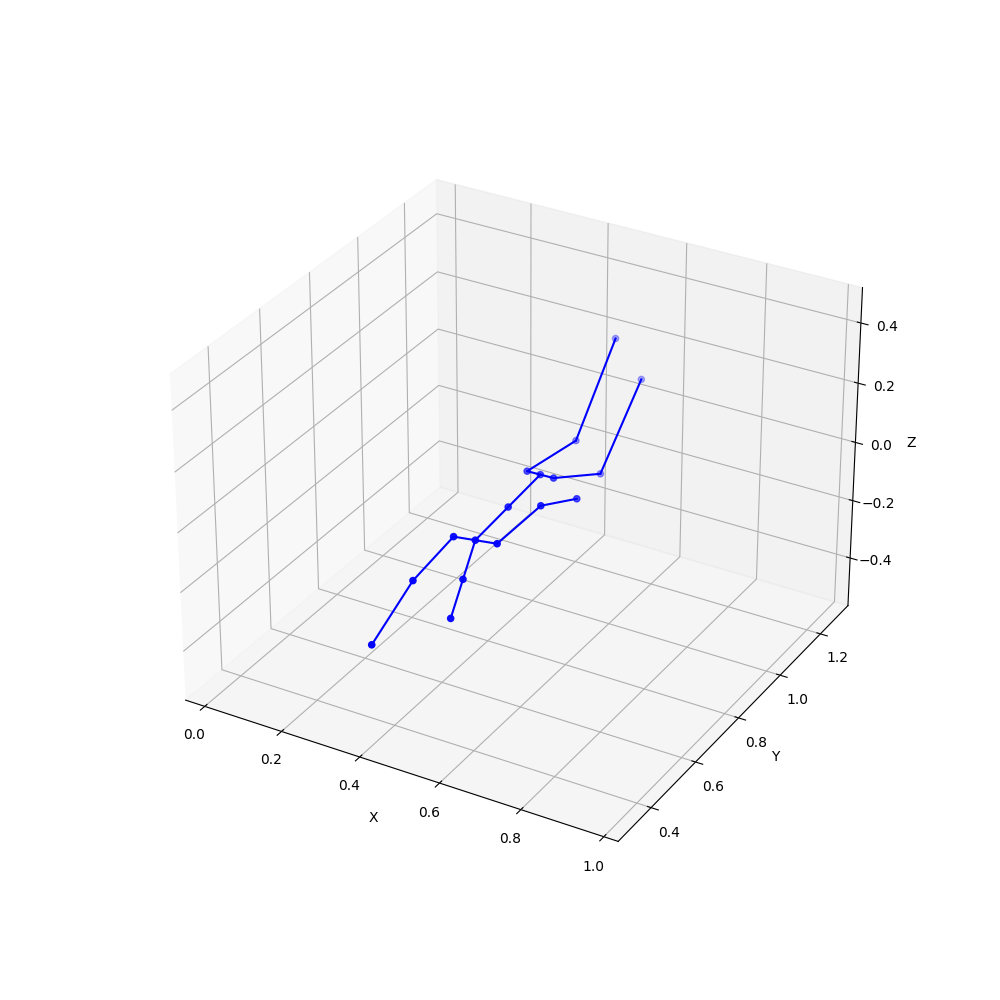

In [44]:
%matplotlib widget
print(rota_skeletons_B.shape)
t=45

ax = pyplot_skeleton(topology, skeletons[t], show=True, color='blue') #output by blazepose
#ax=pyplot_skeleton(topology, rota_skeletons_B[t], ax=ax, show=True, color='red') #in the new reference

torch.Size([279, 17, 3])


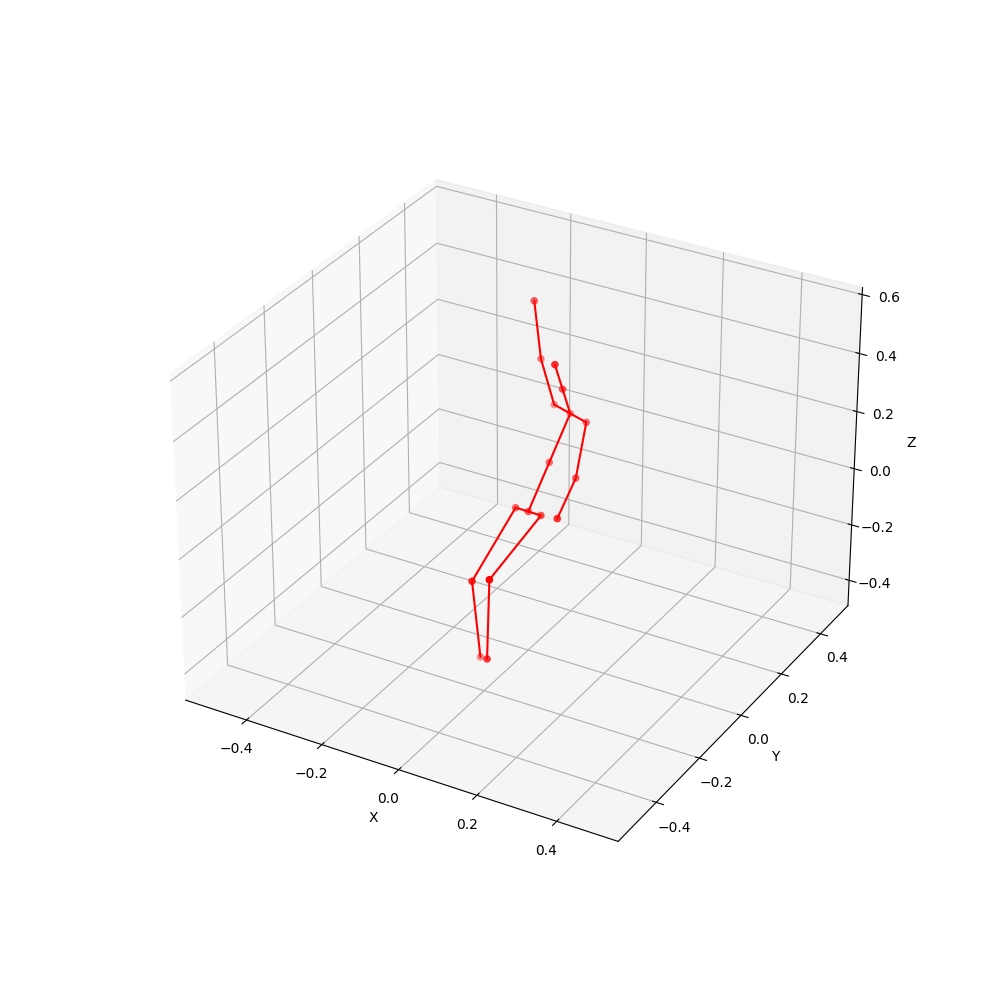

In [41]:
%matplotlib widget
print(rota_skeletons_B.shape)
t=45

#ax = pyplot_skeleton(topology, rota_skeletons_B[t], show=True, color='blue') #output by blazepose
ax=pyplot_skeleton(topology, rota_skeletons_B[t], ax=ax, show=True, color='red') #in the new reference

Then, this function computes target XYZ positions for Poppy's kinematic chains' end effectors based on the skeleton obtained from blazepose. It proceeds as follows:
- it estimates the source (i.e. video) bone lengths
- it estimates the source (i.e. video) joint orientations using the "find_quaternions" util function
- it reorients all the joint angles using as base orientation the pelvis -> chest axis
- it computes the XYZ joint positions based on the found orientations and the poppy bone lengths

A little trick is then applied, but could be removed. To decrease the depth of the movement estimated by blazepose, the y-axis values are divided by 10. To ensure that the target positions still correspond to achievable positions by the robot, we do another round of XYZ positions -> joint orientations -> XYZ positions.

Finally, this function returns the joint XYZ positions only for kinematic chaine end effectors.

In [24]:
def targets_from_skeleton(source_positions, topology):
    # Works in batched
    batch_size, n_joints, _ = source_positions.shape
    
    # Measure skeleton bone lengths
    source_lengths = torch.Tensor(batch_size, n_joints)
    for child, parent in enumerate(topology):
        source_lengths[:, child] = torch.sqrt(
            torch.sum(
                (source_positions[:, child] - source_positions[:, parent])**2,
                axis=-1
            )
        )
    
    # Find the corresponding angles
    source_offsets = torch.zeros(batch_size, n_joints, 3)
    source_offsets[:, :, -1] = source_lengths
    quaternions = find_quaternions(topology, source_offsets, source_positions)
    
    # Re-orient according to the pelvis->chest orientation
    base_orientation = quaternions[:, 7:8].repeat(1, n_joints, 1).reshape(batch_size*n_joints, 4)
    base_orientation += 1e-3 * torch.randn_like(base_orientation)
    quaternions = quaternions.reshape(batch_size*n_joints, 4)
    quaternions = batch_quat_left_multiply(
        batch_quat_inverse(base_orientation),
        quaternions
    )
    quaternions = quaternions.reshape(batch_size, n_joints, 4)
    
    # Use these quaternions in the forward kinematics with the Poppy skeleton
    target_offsets = torch.zeros(batch_size, n_joints, 3)
    target_offsets[:, :, -1] = poppy_lengths.unsqueeze(0).repeat(batch_size, 1)
    target_positions = forward_kinematics(
        topology,
        torch.zeros(batch_size, 3),
        target_offsets,
        quaternions
    )[0]

    # Measure the hip orientation
    alpha = np.arctan2(
        target_positions[0, 1, 1] - target_positions[0, 0, 1],
        target_positions[0, 1, 0] - target_positions[0, 0, 0]
    )
    
    # Rotate by alpha around z
    alpha = alpha
    rotation = torch.Tensor([np.cos(alpha/2), 0, 0, np.sin(alpha/2)]).unsqueeze(0).repeat(batch_size*n_joints, 1)
    quaternions = quaternions.reshape(batch_size*n_joints, 4)
    quaternions = batch_quat_left_multiply(
        batch_quat_inverse(rotation),
        quaternions
    )
    quaternions = quaternions.reshape(batch_size, n_joints, 4)
    
    # Use these quaternions in the forward kinematics with the Poppy skeleton
    target_positions = forward_kinematics(
        topology,
        torch.zeros(batch_size, 3),
        target_offsets,
        quaternions
    )[0]
    

    
    # Return only target positions for the end-effector of the 6 kinematic chains:
    # Chest, head, left hand, left elbow, left shoulder, right hand, right elbow
    # end_effector_indices = [8, 10, 13, 12, 11, 16, 15]
    end_effector_indices = [13, 16]
    # end_effector_indices = [13, 12, 16, 15]

    return target_positions[:, end_effector_indices], target_positions

In [25]:
poppy_lengths = torch.Tensor([
    0.0,
    0.07,
    0.18,
    0.19,
    0.07,
    0.18,
    0.19,
    0.12,
    0.08,
    0.07,
    0.05,
    0.1, 
    0.15,
    0.13,
    0.1,
    0.15,
    0.13
])

In [26]:
targets, all_positions = targets_from_skeleton(skeletons, topology)

In [46]:
print(targets.shape)
targets[10]

torch.Size([279, 2, 3])


tensor([[ 0.1535, -0.1102, -0.0004],
        [-0.1670, -0.1631,  0.0210]])

In [47]:
print(all_positions.shape)
all_positions[10]

torch.Size([279, 17, 3])


tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 6.8765e-02,  1.2849e-02, -2.5101e-03],
        [ 8.0305e-02, -9.9878e-02, -1.4237e-01],
        [ 7.0588e-02, -2.1538e-02, -3.1519e-01],
        [-6.8696e-02, -1.3276e-02,  2.1582e-03],
        [-6.4653e-02, -8.6578e-02, -1.6219e-01],
        [-8.0283e-02, -1.6897e-02, -3.3826e-01],
        [-7.2188e-05, -1.5024e-04,  1.2000e-01],
        [-3.3333e-04, -2.1928e-04,  2.0000e-01],
        [ 4.0531e-03, -3.7508e-02,  2.5908e-01],
        [ 7.2670e-03, -6.4217e-02,  3.0122e-01],
        [ 9.8837e-02,  1.2501e-02,  1.9815e-01],
        [ 1.1775e-01,  4.4339e-03,  4.9564e-02],
        [ 1.5349e-01, -1.1015e-01, -3.6328e-04],
        [-9.9473e-02, -1.3200e-02,  2.0167e-01],
        [-1.3854e-01, -4.2286e-02,  5.9797e-02],
        [-1.6698e-01, -1.6307e-01,  2.1038e-02]])

We can display the target skeleton with stars representing the end-effector target positions.

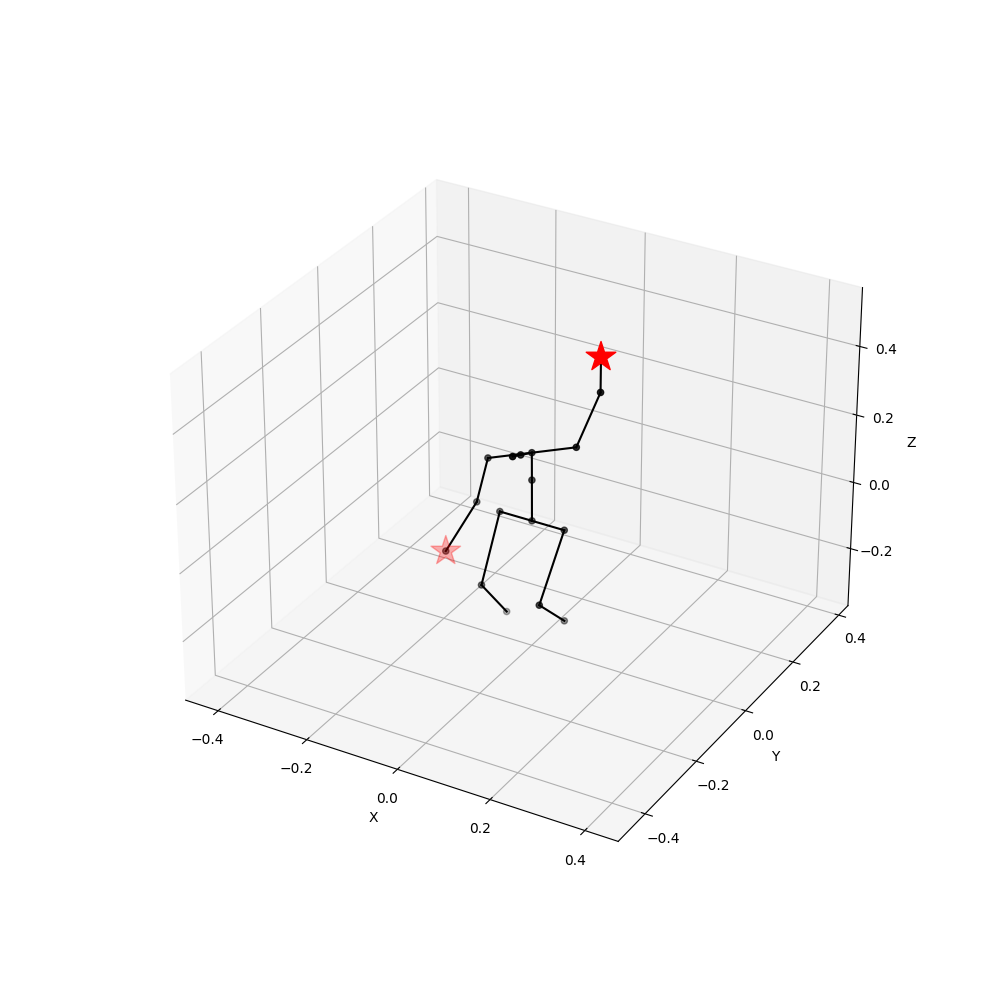

In [42]:
%matplotlib widget

t = t if t is not None else 0
t = -100

ax = pyplot_skeleton(topology, all_positions[t], show=False)
ax.scatter(targets[t, :, 0], targets[t, :, 1], targets[t, :, 2], c='red', s=500, marker='*')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
set_axes_equal(ax)
plt.show()

For smoother movements, we compute a moving average of the target positions.

In [29]:
def moving_average(a, n=3) :
    repeat_shape = list(a.shape)
    repeat_shape[1:] = [1 for _ in range(len(repeat_shape)-1)]
    repeat_shape[0] = n//2
    a = torch.cat([a[:1].repeat(*repeat_shape), a, a[-2:].repeat(*repeat_shape)])
    ret = torch.cumsum(a, axis=0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [30]:
# Can be used to have more keypoints for the inverse kinematics. It could be useful for fast movements.
# With factor=1, it does nothing
def interpolate_targets(targets, factor=1):
    
    length, joints, _ = targets.shape
    
    new_targets = torch.zeros((length-1) * factor + 1, joints, 3)
    
    for i in range(new_targets.shape[0]):
            
        target_id = float(i/factor)
        before_id = int(np.floor(target_id))
        after_id = int(np.floor(target_id + 1))
        
        before_coef = 1 - (target_id - before_id)
        after_coef = 1 - (after_id - target_id)
        
        if after_id > length - 1:
            after_id = length - 1
        
        new_targets[i] = before_coef * targets[before_id] + after_coef * targets[after_id]
        
    return new_targets

In [31]:
targets.shape

torch.Size([279, 2, 3])

In [32]:
interpolated_targets = interpolate_targets(targets)
smoothed_targets = moving_average(interpolated_targets, n=15)

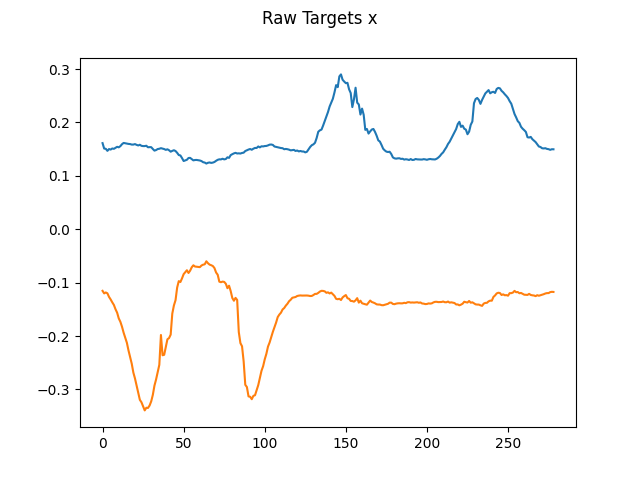

In [33]:
plt.figure()
plt.plot(targets[:, :, 0])
plt.suptitle('Raw Targets x')
plt.show()

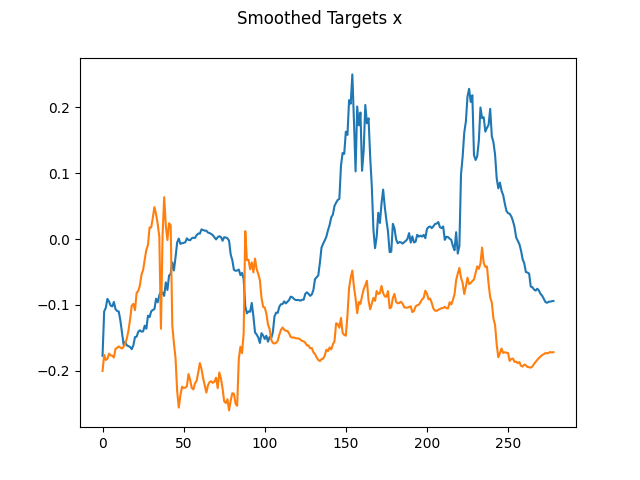

In [34]:
plt.figure()
plt.plot(targets[:, :, 1])
plt.suptitle('Smoothed Targets x')
plt.show()

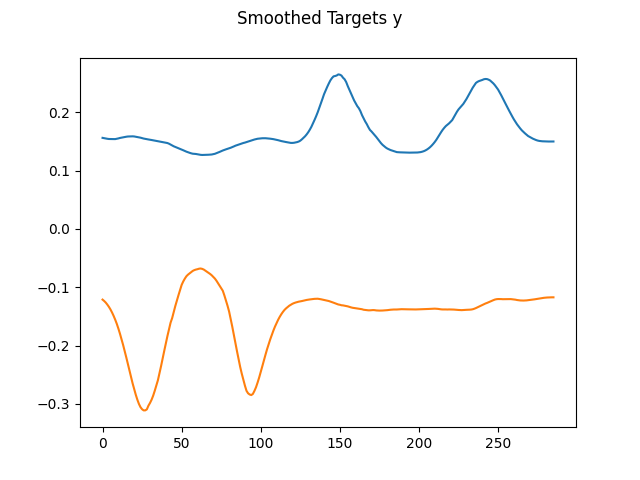

In [35]:
plt.figure()
plt.plot(smoothed_targets[:, :, 0])
plt.suptitle('Smoothed Targets y')
plt.show()

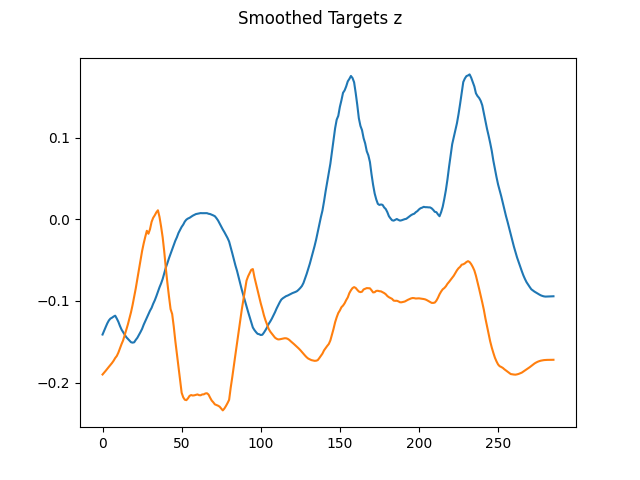

In [36]:
plt.figure()
plt.plot(smoothed_targets[:, :, 1])
plt.suptitle('Smoothed Targets z')
plt.show()

These two functions perform inverse kinematics combining multiple kinematic chains at the same time. The upper_body_imitation uses torso, head, elbows and hands targets, while the arms_imitation only focuses on the two hands.

If positions are provided, its uses it as initial positions, otherwise, it uses the current simulated robot configuration.

In [40]:
import time

In [41]:
def dict_from_position(kinematic_chains, positions):
    
    results = {}
    
    for kc, joint_positions in zip(kinematic_chains, positions):       

        for i, (motor, motor_position) in enumerate(zip(kc.motors, joint_positions)):
                        
            if motor.name not in enumerate(results.keys()) and kc.active_links_mask[i+1]:
                results[motor.name] = [motor_position, 0.]
                
    return results

In [42]:
def upper_body_imitation(poppy, targets, positions=None):
    
    # Targets should be a tensor of shape (6, 3)
    # In order: chest, head, r_hand, l_hand, l_elbow, r_elbow
    kinematic_chains = [
        #poppy.torso_chain,
        #poppy.head_chain,
        #poppy.l_shoulder_chain,
        poppy.l_arm_chain,
        #poppy.l_hand_chain,
        poppy.r_arm_chain,
    ]
    
    next_positions = []
    
    for i, kinematic_chain in enumerate(kinematic_chains):
        
        if positions is not None:
            next_positions.append(ik(kinematic_chain, targets[i], positions[i]))
        else:
            next_positions.append(ik(kinematic_chain, targets[i]))

    return next_positions

In [43]:
import copy
from pypot.primitive.move import Move

This cell loops along the different frames of the input video and performs frame by frame imitation. It registers the found motor angles in a Move object that stores the whole Poppy movement.

In [44]:
poppy_reset()

In [45]:
fps = 10

for motor in poppy.motors:
    motor.compliant = False

# Upper body imitation seems to work better
# Otherwise, the elbow might go to wrong positions that can block the motion later

kinematic_chains = [
    # poppy.torso_chain,
    #poppy.head_chain,
    #poppy.l_shoulder_chain,
    poppy.l_arm_chain,
    #poppy.l_elbow_chain,
    # poppy.l_hand_chain,
    poppy.r_arm_chain,
    #poppy.r_elbow_chain,
    # poppy.r_hand_chain,
]

#kinematic_chains = [
#    poppy.l_arm_chain,
#    poppy.r_arm_chain,
#]

positions = [k.joints_position for k in kinematic_chains]

move = Move(freq=fps)

for t in range(smoothed_targets.shape[0]):
    time.sleep(1./fps)
    #positions = upper_body_imitation(
    #    poppy, 
    #    smoothed_targets[t],
    #    # positions = positions
    #)

    positions = upper_body_imitation(
        poppy,
        smoothed_targets[t],
    )
        
    move.add_position(
        dict_from_position(kinematic_chains, positions), 
        np.float64(t)/fps
    )

We can plot the evolution of the motor angles during the trajectory. 

In [46]:
%matplotlib widget

ax = plt.axes()
move.plot(ax)
plt.show()

<IPython.core.display.Javascript object>

save this movement to a file

In [47]:
move.save(open('move.record', 'w'))

## Play the saved move in the simulator

In [48]:
poppy_reset()

In [49]:
from pypot.primitive.move import MovePlayer, MoveRecorder

In [50]:
def smoothen_move(move):
    
    # Function to smoothen the Poppy movement
    n = 10
    
    # Create a tensor from the dictionary
    motors = move.positions()[0].keys()
    move_tensor = torch.Tensor([
        [move.positions()[t][motor]  for motor in motors] for t in move.positions().keys()
    ])
    
    # Control the motor range
    move_tensor = torch.minimum(move_tensor, torch.full(move_tensor.shape, 180.))
    move_tensor = torch.maximum(move_tensor, torch.full(move_tensor.shape, -180.))
    
    # Moving average to smoothen the positions
    move_tensor = moving_average(move_tensor, n=n)
    
    # Compute velocity as the (next position - previous positions) * fps / 2
    move_tensor[1:-1, :, 1] = (move_tensor[2:, :, 0] - move_tensor[:-2, :, 0]) * 0.5 * move.framerate
    
    # Rebuild the dictionary from the tensor
    new_move = Move(freq=move.framerate)
        
    for i in range(move_tensor.shape[0]):
        dictionary = {}
        for j, motor in enumerate(motors):
            dictionary[motor] = move_tensor[i, j].tolist()
        new_move.add_position(
            dictionary,
            float(i)/fps
        )

    return new_move

In [51]:
new_move = smoothen_move(move)

In [52]:
mp = MovePlayer(poppy, new_move)

In [53]:
mp.start()

In [54]:
%matplotlib widget

ax = plt.axes()
new_move.plot(ax)
plt.show()

<IPython.core.display.Javascript object>

Finally, we save the move in a file, copy the file through ssh to the poppy robot, and send an API request to play the move. Note that the computer executing the notebook should be on the same network than poppy.

# Your project

Your task is to use the reinforcement learning and inverse reinforcement learning algorithms to learn how Poppy can imitate the movement, without using the inverse kinematics library.

You can use stable baselines or imitation libraries. You can also use your own implementation of the RL or iRL algorithm.
For using the libraries, it is recommended that you create your own gymnamsium environment (NB gymnasium is the new version of gym, it can be used in the previous code by replacing the import line by 'import gymnasium as gym').

- You can refer to the documentation by gym on https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/ or https://www.gymlibrary.dev/content/environment_creation/. They propose a tutorial python notebook
- You can also look at an example project with a similar robot, ErgoJr : https://github.com/fgolemo/gym-ergojr with the gym environment implementation : https://github.com/fgolemo/gym-ergojr/blob/master/gym_ergojr/envs/ergo_reacher_env.py

The action is the joint positions given to each of the motors.
The observation are the cartesian positions that can be accessed by commands like poppy.l_arm_chain.position.


You also need to decide on the reward function to be used.

Two interesting articles to get your inspiration can be read : 

- https://arxiv.org/abs/2209.05135
- https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8956326&casa_token=10GKHz8KJR8AAAAA:OZNWV-X7RxXJqLlRNqMBEtBg7jbH4fyy8pjDiMf5cOT65USEECinEMOiEVj0VW5sUDETHjGVgA&tag=1